In [1]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
from copy import deepcopy
import torch.nn.functional as F
from sklearn import linear_model, model_selection
from sklearn.metrics import make_scorer, accuracy_score
from tqdm.notebook import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

from typing import Callable

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Running on device: CUDA


Downloading the dataset and creating the train_loader, retain_loader, test_loader, forget_loader 

In [2]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "forget_idx.npy"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

100%|██████████| 170498071/170498071 [00:03<00:00, 48435115.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Loading the pretrained model

In [3]:
# download pre-trained weights
local_path = "weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

In [4]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Train set accuracy: 99.5%
Test set accuracy: 88.3%


Creating a retrain model to compare with our unlearning model.

In [5]:
# download weights of a model trained exclusively on the retain set
local_path = "retrain_weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

# print its accuracy on retain and forget set
print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

Retain set accuracy: 99.5%
Forget set accuracy: 88.2%


In [6]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

# def unlearning(net, *args, **kwargs): 
#     """A placeholder prefect unlearning function, which returns 
#     the retrained model. Note there is no randomness in this"""
#     return deepcopy(pretrained_models["retrained"])

In [7]:
data_loaders = {
    "retain" : retain_loader,
    "forget" : forget_loader,
    "validation" : val_loader,
    "testing" : test_loader
}

In [8]:
pretrained_models = {
    "original" : model,
    "retrained" : rt_model
}

In [9]:
def compute_outputs(net, loader):
    """Auxiliary function to compute the logits for all datapoints.
    Does not shuffle the data, regardless of the loader.
    """

    # Make sure loader does not shuffle the data
    if isinstance(loader.sampler, torch.utils.data.sampler.RandomSampler):
        loader = DataLoader(
            loader.dataset, 
            batch_size=loader.batch_size, 
            shuffle=False, 
            num_workers=loader.num_workers)
    
    all_outputs = []
    all_targets = []
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to("cpu")

        logits = net(inputs).detach().cpu().numpy() # (batch_size, num_classes)
        
        all_outputs.append(logits)
        all_targets.extend(targets)
        
    return np.array(all_targets), np.concatenate(all_outputs) # (len(loader.dataset), num_classes)

In [10]:
def cross_entropy_f(x, targets):
    # Convert NumPy array to PyTorch tensor
    x_tensor = torch.from_numpy(x)

    # Apply softmax to the model output
    x_softmax = F.softmax(x_tensor, dim=-1)

    # Convert targets to one-hot encoding
    targets_tensor = torch.from_numpy(targets)
    targets_one_hot = F.one_hot(targets_tensor, num_classes=x_tensor.shape[-1])

    # Avoiding NaN values in x
    x_tensor[torch.isnan(x_tensor)] = 0.0

    # Calculate cross-entropy loss for each example
    loss = -torch.sum(targets_one_hot * torch.log(x_softmax), dim=-1)

    # Convert the result back to a NumPy array if needed
    loss_np = loss.numpy()

    return loss_np
    
    

In [11]:
def false_positive_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false positive rate (FPR)."""
    fp = np.sum(np.logical_and((y_pred == 1), (y_true == 0)))
    n = np.sum(y_true == 0)
    return fp / n


def false_negative_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false negative rate (FNR)."""
    fn = np.sum(np.logical_and((y_pred == 0), (y_true == 1)))
    p = np.sum(y_true == 1)
    return fn / p


# The SCORING dictionary is used by sklearn's `cross_validate` function so that
# we record the FPR and FNR metrics of interest when doing cross validation
SCORING = {
    'false_positive_rate': make_scorer(false_positive_rate),
    'false_negative_rate': make_scorer(false_negative_rate)
}


def logistic_regression_attack(
        outputs_U, outputs_R, n_splits=2, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      outputs_U: numpy array of shape (N)
      outputs_R: numpy array of shape (N)
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      fpr, fnr : float * float
    """
    assert len(outputs_U) == len(outputs_R)
    
    samples = np.concatenate((outputs_R, outputs_U)).reshape((-1, 1))
    labels = np.array([0] * len(outputs_R) + [1] * len(outputs_U))

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    scores =  model_selection.cross_validate(
        attack_model, samples, labels, cv=cv, scoring=SCORING)
    
    fpr = np.mean(scores["test_false_positive_rate"])
    fnr = np.mean(scores["test_false_negative_rate"])
    
    return fpr, fnr

In [12]:
def compute_epsilon_s(fpr: list[float], fnr: list[float], delta: float) -> float:
    """Computes the privacy degree (epsilon) of a particular forget set example, 
    given the FPRs and FNRs resulting from various attacks.
    
    The smaller epsilon is, the better the unlearning is.
    
    Args:
      fpr: list[float] of length m = num attacks. The FPRs for a particular example. 
      fnr: list[float] of length m = num attacks. The FNRs for a particular example.
      delta: float
    Returns:
      epsilon: float corresponding to the privacy degree of the particular example.
    """
    assert len(fpr) == len(fnr)
    
    per_attack_epsilon = [0.]
    for fpr_i, fnr_i in zip(fpr, fnr):
        if fpr_i == 0 and fnr_i == 0:
            per_attack_epsilon.append(np.inf)
        elif fpr_i == 0 or fnr_i == 0:
            pass # discard attack
        else:
            with np.errstate(invalid='ignore'):
                epsilon1 = np.log(1. - delta - fpr_i) - np.log(fnr_i)
                epsilon2 = np.log(1. - delta - fnr_i) - np.log(fpr_i)
            if np.isnan(epsilon1) and np.isnan(epsilon2):
                per_attack_epsilon.append(np.inf)
            else:
                per_attack_epsilon.append(np.nanmax([epsilon1, epsilon2]))
            
    return np.nanmax(per_attack_epsilon)


def bin_index_fn(
        epsilons: np.ndarray, 
        bin_width: float = 0.5, 
        B: int = 13
        ) -> np.ndarray:
    """The bin index function."""
    bins = np.arange(0, B) * bin_width
    return np.digitize(epsilons, bins)


def H(epsilons: np.ndarray) -> float:
    """Computes the forgetting quality given the privacy degrees 
    of the forget set examples.
    """
    ns = bin_index_fn(epsilons)
    hs = 2. / 2 ** ns
    return np.mean(hs)

In [13]:
def forgetting_quality(
        outputs_U: np.ndarray, # (N, S)
        outputs_R: np.ndarray, # (N, S)
        attacks: list[Callable] = [logistic_regression_attack],
        delta: float = 0.01
    ):
    """
    Both `outputs_U` and `outputs_R` are of numpy arrays of ndim 2:
    * 1st dimension coresponds to the number of samples obtained from the 
      distribution of each model (N=512 in the case of the competition's leaderboard) 
    * 2nd dimension corresponds to the number of samples in the forget set (S).
    """
    
    # N = number of model samples
    # S = number of forget samples
    N, S = outputs_U.shape
    
    assert outputs_U.shape == outputs_R.shape, \
        "unlearn and retrain outputs need to be of the same shape"
    
    epsilons = []
    pbar = tqdm(range(S))
    for sample_id in pbar:
        pbar.set_description("Computing F...")
        
        sample_fprs, sample_fnrs = [], []
        
        for attack in attacks: 
            uls = outputs_U[:, sample_id]
            rls = outputs_R[:, sample_id]
            
            fpr, fnr = attack(uls, rls)
            
            if isinstance(fpr, list):
                sample_fprs.extend(fpr)
                sample_fnrs.extend(fnr)
            else:
                sample_fprs.append(fpr)
                sample_fnrs.append(fnr)
        
        sample_epsilon = compute_epsilon_s(sample_fprs, sample_fnrs, delta=delta)
        epsilons.append(sample_epsilon)
        
    return H(np.array(epsilons))

In [14]:
def score_unlearning_algorithm(
        data_loaders: dict, 
        pretrained_models: dict, 
        unlearning: Callable, 
        n: int = 10,
        delta: float = 0.01,
        f: Callable = cross_entropy_f,
        attacks: list[Callable] = [logistic_regression_attack]
        ) -> dict:
    
    retain_loader = data_loaders["retain"]
    forget_loader = data_loaders["forget"]
    val_loader = data_loaders["validation"]
    test_loader = data_loaders["testing"]
    
    original_model = pretrained_models["original"]
    rt_model = pretrained_models["retrained"]
    
    outputs_U = []
    outputs_R = []
    retain_accuracy = []
    test_accuracy = []
    forget_accuracy = []
    
    u_model = deepcopy(original_model)
    for i in range(n):
        print("Running epoch :",i+1)
        
        print("I am now unlearning all the wrong things you taught me!!!")
        
        u_model = unlearning(u_model, retain_loader, forget_loader, val_loader)
        
        targets, outputs_Ui = compute_outputs(u_model, forget_loader)
        
#         print(targets.shape)
#         f_forget = f(outputs_Ui, targets)
#         print(f_forget.shape)
        
        outputs_U.append( f(outputs_Ui, targets) )
        
        print("Computing retain accuracy on Unlearning Model")
        acc = accuracy(u_model, retain_loader)
        print("Retain accuracy on Unlearning Model is ",acc)
        retain_accuracy.append(acc)
        
        print("Computing test accuracy on Unlearning model")
        acc = accuracy(u_model, test_loader)
        print("Test accuracy on Unlearning model is ", acc)
        test_accuracy.append(acc)
        
        print("Computing forget accuracy on Unlearning model")
        acc = accuracy(u_model, forget_loader)
        print("Forget accuracy on Unlearning model is ",acc)
        forget_accuracy.append(acc)
        
    outputs_U = np.array(outputs_U)
    print("Printing outputs_U shape ",outputs_U.shape)
#     print(outputs_U.shape)
    
    assert outputs_U.shape == (n, len(forget_loader.dataset)),\
        "Wrong shape for outputs_U. Should be (num_model_samples, num_forget_datapoints)."
    
    RAR = accuracy(rt_model, retain_loader)
    TAR = accuracy(rt_model, test_loader)
    FAR = accuracy(rt_model, forget_loader)
    
    RAU = np.mean(retain_accuracy)
    TAU = np.mean(test_accuracy)
    FAU = np.mean(forget_accuracy)
    
    RA_ratio = RAU / RAR
    TA_ratio = TAU / TAR
    
    for i in range(n):
        targets, outputs_Ri = compute_outputs(rt_model, forget_loader) #(len(forget_loader.dataset), 10) 
        
        outputs_R.append(f(outputs_Ri, targets) )
    
    outputs_R = np.array(outputs_R)
    print("Printing outputs_R shape ",outputs_R.shape)
    
    f = forgetting_quality(
    outputs_U, 
    outputs_R,
    attacks=attacks,
    delta=delta)
    
    return {
        "total_score": f * RA_ratio * TA_ratio,
        "F": f,
        "unlearn_retain_accuracy": RAU,
        "unlearn_test_accuracy": TAU, 
        "unlearn_forget_accuracy": FAU,
        "retrain_retain_accuracy": RAR,
        "retrain_test_accuracy": TAR, 
        "retrain_forget_accuracy": FAR,
        "retrain_outputs": outputs_R,
        "unlearn_outputs": outputs_U,
        "unlearning_model": u_model
    }

In [15]:
print("Hi")

Hi


In [16]:
len(forget_loader.dataset)

5000

In [17]:
ret = score_unlearning_algorithm(data_loaders, pretrained_models,unlearning,10,0.01,cross_entropy_f)

Running epoch : 1
I am now unlearning all the wrong things you taught me!!!
Computing retain accuracy on Unlearning Model
Retain accuracy on Unlearning Model is  0.9872222222222222
Computing test accuracy on Unlearning model
Test accuracy on Unlearning model is  0.8364
Computing forget accuracy on Unlearning model
Forget accuracy on Unlearning model is  0.8586
Running epoch : 2
I am now unlearning all the wrong things you taught me!!!
Computing retain accuracy on Unlearning Model
Retain accuracy on Unlearning Model is  0.9978444444444444
Computing test accuracy on Unlearning model
Test accuracy on Unlearning model is  0.8328
Computing forget accuracy on Unlearning model
Forget accuracy on Unlearning model is  0.8464
Running epoch : 3
I am now unlearning all the wrong things you taught me!!!
Computing retain accuracy on Unlearning Model
Retain accuracy on Unlearning Model is  0.9992222222222222
Computing test accuracy on Unlearning model
Test accuracy on Unlearning model is  0.8234
Comp

  0%|          | 0/5000 [00:00<?, ?it/s]

In [18]:
ret

{'total_score': 0.6213598266076733,
 'F': 0.661482666015625,
 'unlearn_retain_accuracy': 0.99832,
 'unlearn_test_accuracy': 0.82372,
 'unlearn_forget_accuracy': 0.83398,
 'retrain_retain_accuracy': 0.9952666666666666,
 'retrain_test_accuracy': 0.8796,
 'retrain_forget_accuracy': 0.882,
 'retrain_outputs': array([[1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        ...,
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03

In [19]:
ut_model = ret["unlearning_model"]
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


ut_train_losses = compute_losses(ut_model, train_loader)
ut_test_losses = compute_losses(ut_model, test_loader)
ut_forget_losses = compute_losses(ut_model, forget_loader)

In [20]:
rt_train_losses = compute_losses(rt_model, train_loader)
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

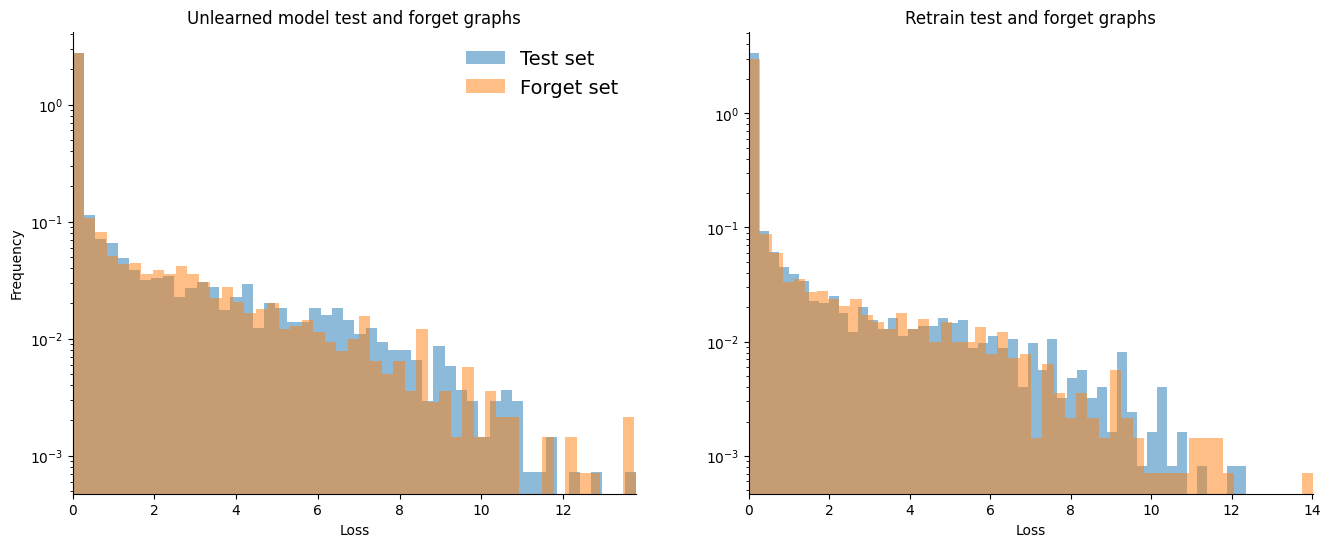

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Unlearned model test and forget graphs")
ax1.hist(ut_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(ut_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Retrain test and forget graphs"
)
ax2.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(ut_test_losses)))
ax2.set_xlim((0, np.max(ut_forget_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

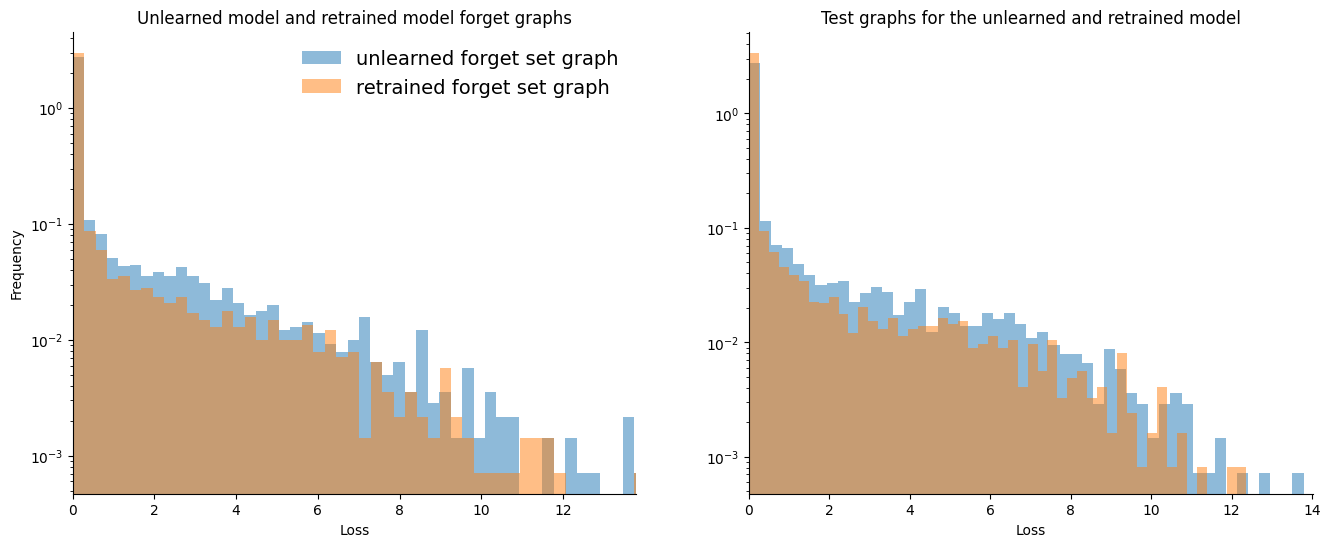

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Unlearned model and retrained model forget graphs")
ax1.hist(ut_forget_losses, density=True, alpha=0.5, bins=50, label="unlearned forget set graph")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="retrained forget set graph")

ax2.set_title(
    f"Test graphs for the unlearned and retrained model"
)
ax2.hist(ut_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(ut_test_losses)))
ax2.set_xlim((0, np.max(ut_forget_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()